In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from libra_toolbox.tritium.model import (
    quantity_to_activity,
    activity_to_quantity,
)
from libra_toolbox.tritium.plotting import (
    ureg,
    plot_bars,
    plot_integrated_top_release,
    plot_integrated_wall_release,
    plot_irradiation,
    plot_sample_activity_top,
    plot_salt_inventory,
    plot_top_release,
    plot_wall_release,
)
ureg.mpl_formatter = "{:~P}"
# remove top and right axes by default
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# set axis below true by default
plt.rcParams["axes.axisbelow"] = True

from baby_run_6 import *

In [2]:
from pathlib import Path

# create baby_run_3 output directory
output_dir = Path("baby_run_6")
output_dir.mkdir(exist_ok=True)

In [3]:
baby_model.run(7 * ureg.day)


/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


In [4]:
print(f"Transport:")
print(f"  mass transport coeff top: {baby_model.k_top:.2e~P}")
print(f"  mass transport coeff wall: {baby_model.k_wall:.2e~P}")

print("Source:")
print(f"  TBR: {baby_model.TBR:.2e~P}")
print(f"  neutron rate: {baby_model.neutron_rate:.2e~P}")
print(f"  neutron rate * TBR: {baby_model.neutron_rate * baby_model.TBR:.2e~P}")
print(f"  k_top/k_wall: {baby_model.k_top/baby_model.k_wall:.2f~P}")

print("Geometry:")
print(f"  volume: {baby_model.volume.to(ureg.cm**3):.2f~P}")
print(f"  top area: {baby_model.A_top.to(ureg.cm**2):.2f~P}")
print(f"  wall area: {baby_model.A_wall.to(ureg.cm**2):.2f~P}")

Transport:
  mass transport coeff top: 1.03×10⁻⁶ m/s
  mass transport coeff wall: 3.09×10⁻⁸ m/s
Source:
  TBR: 4.71×10⁻⁴ particle/n
  neutron rate: 3.54×10⁸ n/s
  neutron rate * TBR: 1.67×10⁵ particle/s
  k_top/k_wall: 33.33
Geometry:
  volume: 100.00 cm³
  top area: 13.80 cm²
  wall area: 116.18 cm²


[0.0 43.24324324324324 86.48648648648648 ... 603848.6486486486 604324.3243243243 604800.0] second


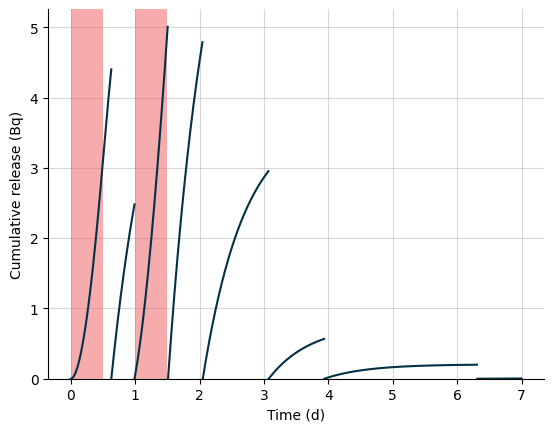

In [5]:
print(baby_model.times)
plot_sample_activity_top(baby_model, replacement_times=replacement_times, color="#023047", label="Top")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.ylim(bottom=0 * ureg.Bq)

plt.ylabel(f"Cumulative release ({plt.gca().yaxis.get_units():~P})")
plt.xlabel(f"Time ({plt.gca().xaxis.get_units():~P})")
plt.grid(alpha=0.5)

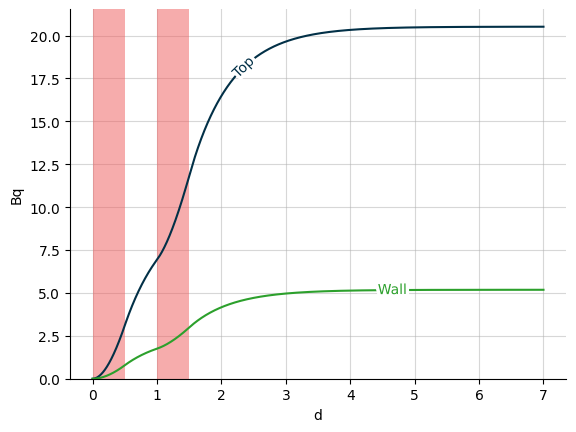

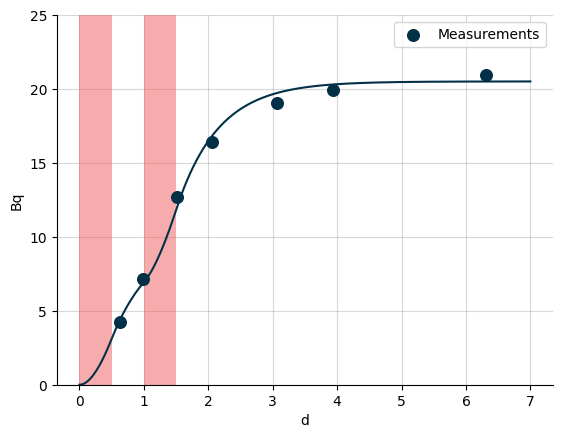

In [6]:
plt.figure()
plot_integrated_top_release(baby_model, color="#023047", label="Top")
plot_integrated_wall_release(baby_model, color="tab:green", label="Wall")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.grid(alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.ylim(bottom=0 * ureg.Bq)
plt.savefig("baby_run_6/cumulative_tritium_release_no_exp.svg")

plt.figure()
plot_integrated_top_release(baby_model, color="#023047", label="Top")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)

plt.grid(alpha=0.5)
plt.ylim(bottom=0 * ureg.Bq)
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
    color="#023047"
)
plt.legend(handles=[s])
plt.ylim(top=25 * ureg.Bq)
plt.savefig("baby_run_6/cumulative_tritium_release.svg")
plt.savefig("baby_run_6/cumulative_tritium_release.pdf")



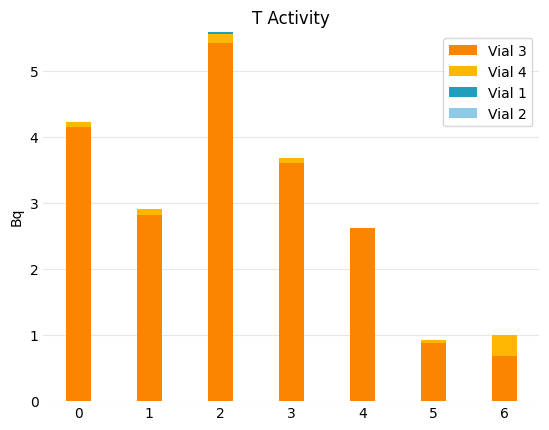

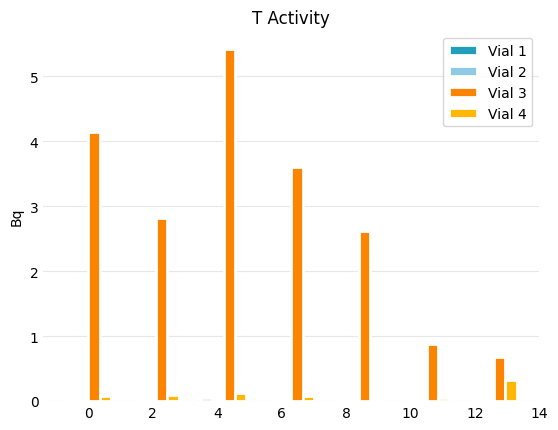

In [7]:
# Create the stacked bar plot

plt.figure()

for stacked in [True, False]:
    index = plot_bars(measurements_after_background_sub, stacked=stacked)
    # plt.xticks(index, ["Day 1", "Day 2", "Day 4"])
    plt.title("T Activity")
    plt.legend()
    plt.gca().spines[["right", "bottom", "top", "left"]].set_visible(False)
    plt.grid(True, axis="y", alpha=0.3)
    plt.gca().tick_params(axis="both", which="both", length=0)
    if stacked:
        plt.savefig("baby_run_6/LSC results_stacked.svg")
    else:
        plt.savefig("baby_run_6/LSC results.svg")
    plt.show()

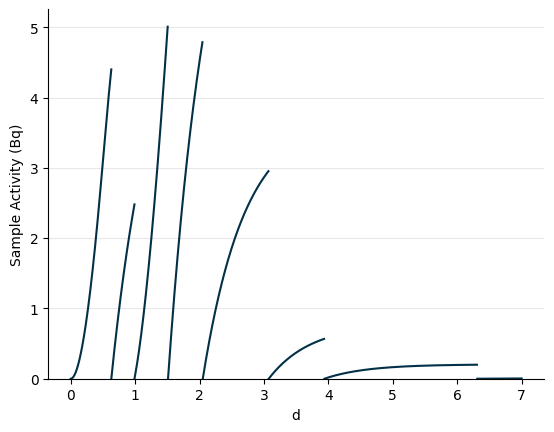

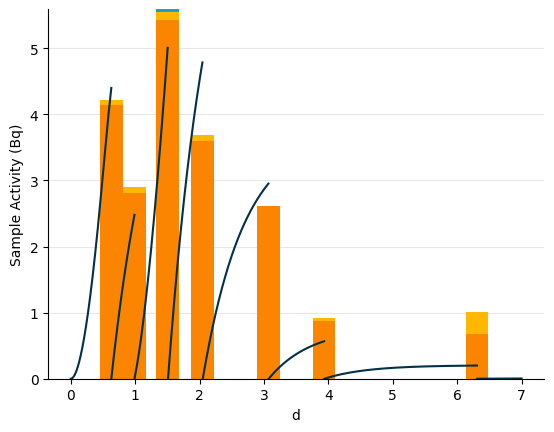

In [8]:
plt.figure()
plot_sample_activity_top(baby_model, replacement_times=replacement_times, color="#023047", label="Model")
plt.grid(True, axis="y", alpha=0.3)
plt.ylim(bottom=0 * ureg.Bq)
plt.ylabel("Sample Activity (Bq)")
plt.savefig("baby_run_6/sample_activity_no_exp.svg")

plt.figure()
plot_bars(measurements_after_background_sub, index=[time.to(ureg.day) for time in replacement_times])
plot_sample_activity_top(baby_model, replacement_times=replacement_times, color="#023047", label="Model")

plt.grid(True, axis="y", alpha=0.3)
plt.ylim(bottom=0 * ureg.Bq)
plt.ylabel("Sample Activity (Bq)")
plt.savefig("baby_run_6/sample_activity.svg")
plt.savefig("baby_run_6/sample_activity.pdf")


In [10]:
modification_factors = np.linspace(0.7, 1.3, 15)
models = []
for modif_factor in modification_factors:
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
        neutron_rate=baby_model.neutron_rate,
        k_top=baby_model.k_top,
        k_wall=baby_model.k_wall,
        irradiations=baby_model.irradiations,
    )

    new_baby_model.run(7 * ureg.day)
    models.append(new_baby_model)


/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1644765/3275039918.py:77: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$k_\mathrm{top}$ (m/s)")
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/interpolate/_polyint.py:121: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  yi = np.asarray(yi)
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:288: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = array(x, copy=self.copy)
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:289: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = array(y, copy=self.copy)


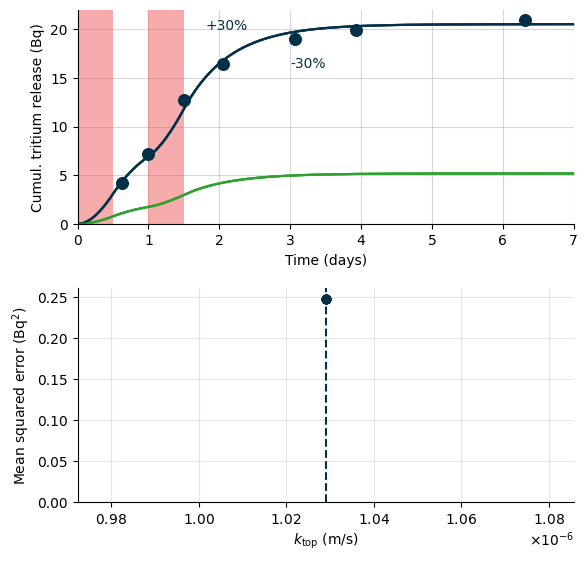

In [11]:
from scipy.interpolate import interp1d

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6.4))

plt.sca(axs[0])
model_to_error = {}
plot_irradiation(models[0], facecolor="#EF5B5B", alpha=0.5)

for i, new_baby_model in enumerate(models[::3]):
    plot_integrated_top_release(new_baby_model, color="#023047", alpha=0.6)
    plot_integrated_wall_release(new_baby_model, color="tab:green", alpha=0.6)

plt.fill_between(
    new_baby_model.times.to(ureg.day),
    quantity_to_activity(models[0].integrated_release_top()).to(ureg.Bq),
    quantity_to_activity(models[-1].integrated_release_top()).to(ureg.Bq),
    color="#023047",
    alpha=0.4,
)

plt.fill_between(
    new_baby_model.times.to(ureg.day),
    quantity_to_activity(models[0].integrated_release_wall()).to(ureg.Bq),
    quantity_to_activity(models[-1].integrated_release_wall()).to(ureg.Bq),
    color="tab:green",
    alpha=0.4,
)


s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    color="#023047",
)
plt.ylim(bottom=0*ureg.Bq)
plt.xlim(0*ureg.day, 7 * ureg.day)
plt.xlabel("Time (days)")
plt.ylabel(f"Cumul. tritium release (Bq)")
plt.grid(alpha=0.5)

plt.annotate("+30%", xy=(1.8 * ureg.days, 20 * ureg.Bq), color="#023047")
plt.annotate("-30%", xy=(3.0 * ureg.days, 16 * ureg.Bq), color="#023047")

plt.sca(axs[1])

model_to_error = {}
for new_baby_model in models:
    integrated_top = quantity_to_activity(new_baby_model.integrated_release_top()).to(
            ureg.Bq
        )
    integrated_top = interp1d(new_baby_model.times.to(ureg.day), integrated_top)
    MSE = 0
    for i, sample_time in enumerate(replacement_times):
        computed_release = integrated_top(sample_time.to(ureg.day)) * ureg.Bq
        measured_release = cumulative_release[i]
        MSE += (computed_release - measured_release)**2
    MSE /= len(replacement_times)
    model_to_error[new_baby_model] = MSE

plt.plot(
    ureg.Quantity.from_list([model.k_top for model in list(model_to_error.keys())]),
    ureg.Quantity.from_list(list(model_to_error.values())),
    color="#023047",
    marker="o",
)

plt.ylim(bottom=0)
plt.grid(alpha=0.3)
plt.axvline(x=baby_model.k_top, color="#023047", linestyle="dashed")
# write optimum value
plt.annotate(
    f"Optimum value: \n {baby_model.k_top:.2e~P}",
    xy=(baby_model.k_top * 1.02, 1.5 * ureg.Bq**2),
    color="#023047",
)
plt.xlabel("$k_\mathrm{top}$ (m/s)")
plt.ylabel("Mean squared error (Bq$^2$)")
plt.gca().xaxis.major.formatter._useMathText = True
plt.subplots_adjust(hspace=0.3)
plt.savefig("baby_run_6/optimisation_k_top.svg")
plt.savefig("baby_run_6/optimisation_k_top.pdf")

In [12]:
m = measurements_after_background_sub

efficiency_1 = m[1][3] / (m[1][3] + m[1][4])
efficiency_2 = m[2][3] / (m[2][3] + m[2][4])
efficiency_3 = m[3][3] / (m[3][3] + m[3][4])
efficiency_4 = m[4][3] / (m[4][3] + m[4][4])
efficiency_5 = m[5][3] / (m[5][3] + m[5][4])
efficiency_6 = m[6][3] / (m[6][3] + m[6][4])
efficiency_7 = m[7][3] / (m[7][3] + m[7][4])


average_efficiency = np.mean(
    [
        efficiency_1,
        efficiency_2,
        efficiency_3,
        efficiency_4,
        efficiency_5,
        efficiency_6,
        efficiency_7,
    ]
)

nb_vials = 2
total_eff = 1 - (1 - average_efficiency) ** nb_vials

print(f"Efficiency of 1 vial: {average_efficiency:.2%}")
print(f"Efficiency of {nb_vials} vials: {total_eff:.2%}")



Efficiency of 1 vial: 93.26%
Efficiency of 2 vials: 99.55%


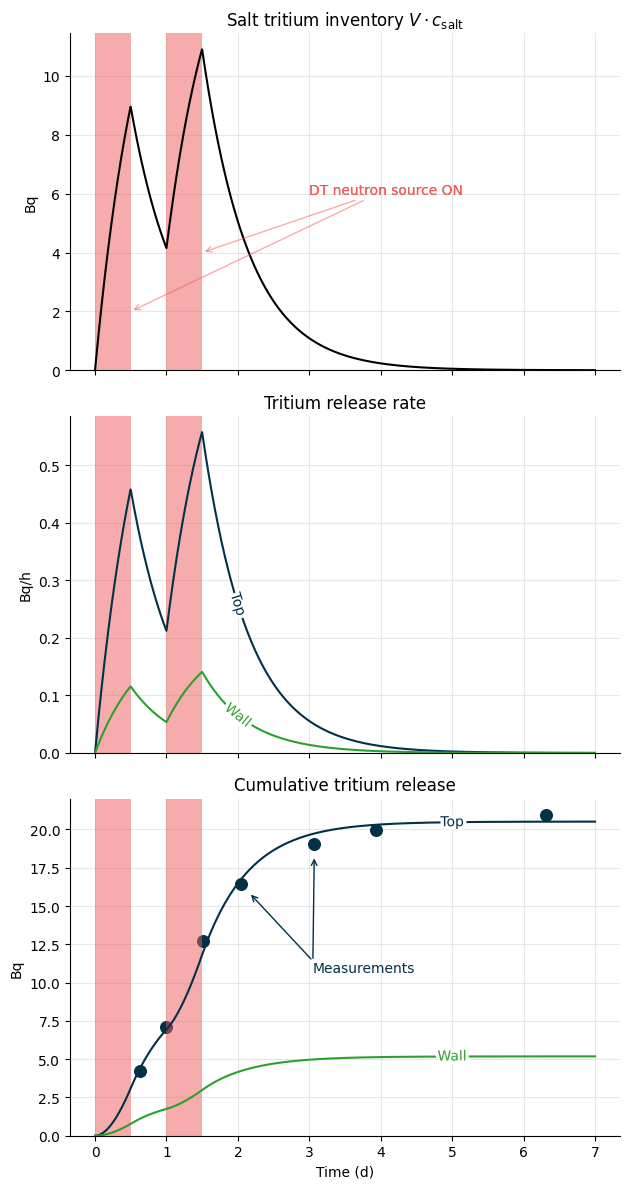

In [13]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title(r"Salt tritium inventory $V \cdot c_\mathrm{salt}$")

plot_salt_inventory(baby_model, color="black")

plt.sca(ax_fluxes)
plt.title("Tritium release rate")
plot_top_release(baby_model, color="#023047", label="Top")
plot_wall_release(baby_model, color="tab:green", label="Wall")

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")

plot_integrated_top_release(baby_model, color="#023047", label="Top")
plot_integrated_wall_release(baby_model, color="tab:green", label="Wall")
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
    color="#023047",
)
plt.xlabel(f"Time ({time.units:~P})")



for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3)

    plt.sca(ax)
    plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)


labelLines(ax_fluxes.get_lines(), zorder=2.5, xvals=(2, 2))
labelLines(ax_cumul.get_lines(), zorder=2.5, xvals=(5, 5))

ax_inv.annotate(
    "DT neutron source ON",
    xy=(1.5 * ureg.day, 4 * ureg.Bq),
    xytext=(3 * ureg.days, 6 * ureg.Bq),
    color="#EF5B5B",
    arrowprops=dict(arrowstyle='->', color="#EF5B5B", alpha=0.5),
)
ax_inv.annotate(
    "DT neutron source ON",
    xy=(0.5 * ureg.day, 2 * ureg.Bq),
    xytext=(3 * ureg.days, 6 * ureg.Bq),
    color="#EF5B5B",
    arrowprops=dict(arrowstyle='->', color="#EF5B5B", alpha=0.5),
)

ax_cumul.annotate(
    "",
    xy=(replacement_times[3], cumulative_release[3]),
    xytext=(replacement_times[3] + 1 * ureg.day, cumulative_release[3] - 5 * ureg.Bq),
    arrowprops=dict(arrowstyle='->', color="#023047", shrinkB=10),
)
ax_cumul.annotate(
    "",
    xy=(replacement_times[4], cumulative_release[4]),
    xytext=(replacement_times[3] + 1 * ureg.day, cumulative_release[3] - 5 * ureg.Bq),
    arrowprops=dict(arrowstyle='->', color="#023047", shrinkB=10),
)
ax_cumul.annotate(
    "Measurements",
    color="#023047",
    xy=(replacement_times[4], cumulative_release[4]),
    xytext=(replacement_times[3] + 1 * ureg.day, cumulative_release[3] - 5 * ureg.Bq),
    va = "top", ha="left"
)


plt.tight_layout()
plt.savefig("baby_run_6/basic_model_results.svg")
plt.savefig("baby_run_6/basic_model_results.pdf")
plt.show()

In [14]:
import h_transport_materials as htm
print(f"HTM version {htm.__version__}")
flibe_diffusivities = htm.diffusivities.filter(material=[htm.FLIBE, htm.FLINAK])
temp = htm.ureg.Quantity(700, htm.ureg.degC).to(htm.ureg.K)
L = baby_model.height
sh_numbers = []
for flibe_D in flibe_diffusivities:
    if flibe_D.range[0] <= temp <= flibe_D.range[1]:
        D = flibe_D.value(temp).magnitude * ureg.m**2 * ureg.s**-1
        sherwood_nb = baby_model.k_top/(D /L)
        sh_numbers.append(sherwood_nb.to(ureg.dimensionless).magnitude)
        print(f"{sherwood_nb.to(ureg.dimensionless):.1f}")

print(f"Average Sh number: {np.mean(sh_numbers):.1f}")
print(f"Median Sh number: {np.median(sh_numbers):.1f}")

HTM version 0.17
6.7 dimensionless
24.4 dimensionless
0.9 dimensionless
1.9 dimensionless
14.4 dimensionless
9.2 dimensionless
24.3 dimensionless
11.5 dimensionless
Average Sh number: 11.7
Median Sh number: 10.4


In [15]:
S = (baby_model.neutron_rate * baby_model.TBR).to(ureg.particle / ureg.h)
print(
    f"Source of tritium (modelled): \n  {S:.2e~P} \n  {quantity_to_activity(S).to(ureg.Bq / ureg.hour):.2f~P}"
)

irradiation_time = sum([irr[1] - irr[0] for irr in baby_model.irradiations])
S_measured = (
    activity_to_quantity(cumulative_release[-1]).to(ureg.particle) / irradiation_time
)
print(
    f"Source of tritium (measured top only): \n  {S_measured:.2e~P} \n  {quantity_to_activity(S_measured).to(ureg.Bq / ureg.hour):.2f~P}"
)

integrated_wall = quantity_to_activity(baby_model.integrated_release_wall())

S_measured = (
    activity_to_quantity(cumulative_release[-1] + integrated_wall[-1]).to(ureg.particle)
    / irradiation_time
)
print(
    f"Source of tritium (measured + assumption): \n  {S_measured:.2e~P} \n  {quantity_to_activity(S_measured).to(ureg.Bq / ureg.hour):.2f~P}"
)

Source of tritium (modelled): 
  6.00×10⁸ particle/h 
  1.07 Bq/h
Source of tritium (measured top only): 
  4.88×10⁸ particle/h 
  0.87 Bq/h
Source of tritium (measured + assumption): 
  6.09×10⁸ particle/h 
  1.09 Bq/h


Quantity of T consumed: 3.06×10¹³ particle
Uncertainty on T consumed: 2.72×10¹² particle
Quantity of T consumed: 5.47×10⁴ Bq
Quantity of T produced: 2.10×10¹ Bq
Quantity of T produced: 1.17×10¹⁰ particle
Measured TBR: 3.83e-04
1.2291330524634743 dimensionless


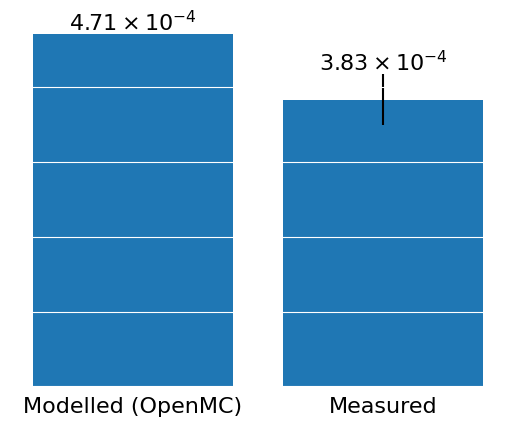

In [16]:
T_consumed = baby_model.neutron_rate * 24 * ureg.hour
T_produced = cumulative_release[-1]
TBR_measured = (T_produced / quantity_to_activity(T_consumed)).to(ureg.dimensionless).magnitude
print(f"Quantity of T consumed: {T_consumed.to(ureg.particle):.2e~P}")
print(f"Uncertainty on T consumed: {(neutron_rate_relative_uncertainty * T_consumed).to(ureg.particle):.2e~P}")
print(f"Quantity of T consumed: {quantity_to_activity(T_consumed).to(ureg.Bq):.2e~P}")
print(f"Quantity of T produced: {cumulative_release[-1]:.2e~P}")
print(f"Quantity of T produced: {activity_to_quantity(cumulative_release[-1]).to(ureg.particle):.2e~P}")
print(f"Measured TBR: {TBR_measured:.2e}")

bars = plt.bar(
    [0, 1],
    [calculated_TBR, TBR_measured],
    tick_label=["Modelled (OpenMC)", "Measured"],
    yerr=[0, neutron_rate_relative_uncertainty * TBR_measured],
)

from libra_toolbox.tritium.helpers import ScalarFormatterClass

mf = ScalarFormatterClass(useMathText=True)
plt.bar_label(bars, fmt=lambda x: "${}$".format(mf.format_data(x)), fontsize=16)
# plt.title("TBR", weight="bold", fontsize=16)
plt.ylabel("")
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels
plt.gca().tick_params(axis="both", which="both", left=False, bottom=False, labelsize=16)
plt.gca().set_axisbelow(False)
plt.grid(axis="y", alpha=1, color="white", zorder=-10)
plt.savefig("baby_run_6/TBR_comparison.svg")
plt.savefig("baby_run_6/TBR_comparison.pdf")
plt.savefig("baby_run_6/TBR_comparison.png")
print((calculated_TBR/TBR_measured).to(ureg.dimensionless))
plt.show()

In [17]:
import h_transport_materials as htm
print(f"HTM version {htm.__version__}")
flibe_diffusivities = htm.diffusivities.filter(material=[htm.FLIBE, htm.FLINAK])
temp = htm.ureg.Quantity(700, htm.ureg.degC).to(htm.ureg.K)
L = baby_model.height
sh_numbers = []
for flibe_D in flibe_diffusivities:
    if flibe_D.range[0] <= temp <= flibe_D.range[1]:
        D = flibe_D.value(temp).magnitude * ureg.m**2 * ureg.s**-1
        sherwood_nb = baby_model.k_top/(D /L)
        sh_numbers.append(sherwood_nb.to(ureg.dimensionless).magnitude)
        print(f"{sherwood_nb.to(ureg.dimensionless):.1f}")

print(f"Average Sh number: {np.mean(sh_numbers):.1f}")
print(f"Median Sh number: {np.median(sh_numbers):.1f}")

HTM version 0.17
6.7 dimensionless
24.4 dimensionless
0.9 dimensionless
1.9 dimensionless
14.4 dimensionless
9.2 dimensionless
24.3 dimensionless
11.5 dimensionless
Average Sh number: 11.7
Median Sh number: 10.4


In [18]:
S = (baby_model.neutron_rate * baby_model.TBR).to(ureg.particle / ureg.h)
print(
    f"Source of tritium (modelled): \n  {S:.2e~P} \n  {quantity_to_activity(S).to(ureg.Bq / ureg.hour):.2f~P}"
)

irradiation_time = sum([irr[1] - irr[0] for irr in baby_model.irradiations])
S_measured = (
    activity_to_quantity(cumulative_release[-1]).to(ureg.particle) / irradiation_time
)
print(
    f"Source of tritium (measured top only): \n  {S_measured:.2e~P} \n  {quantity_to_activity(S_measured).to(ureg.Bq / ureg.hour):.2f~P}"
)

integrated_wall = quantity_to_activity(baby_model.integrated_release_wall())

S_measured = (
    activity_to_quantity(cumulative_release[-1] + integrated_wall[-1]).to(ureg.particle)
    / irradiation_time
)
print(
    f"Source of tritium (measured + assumption): \n  {S_measured:.2e~P} \n  {quantity_to_activity(S_measured).to(ureg.Bq / ureg.hour):.2f~P}"
)

Source of tritium (modelled): 
  6.00×10⁸ particle/h 
  1.07 Bq/h
Source of tritium (measured top only): 
  4.88×10⁸ particle/h 
  0.87 Bq/h
Source of tritium (measured + assumption): 
  6.09×10⁸ particle/h 
  1.09 Bq/h


In [19]:
k_top_factor_range = np.logspace(-1, 0.1, 10)
k_top_to_k_wall_ratio_range = np.logspace(-2, 0, 10)

ZZ = np.zeros((len(k_top_factor_range), len(k_top_to_k_wall_ratio_range)))
for i, k_top_factor in enumerate(k_top_factor_range):
    for j, k_top_to_k_wall_ratio in enumerate(k_top_to_k_wall_ratio_range):
        new_baby_model = Model(
            radius=baby_radius,
            height=baby_height,
            TBR=baby_model.TBR,
            k_top=baby_model.k_top * k_top_factor,
            k_wall=baby_model.k_top * k_top_to_k_wall_ratio,
            neutron_rate=baby_model.neutron_rate,
            irradiations=baby_model.irradiations,
        )


        new_baby_model.run(7 * ureg.day)
        integrated_top = quantity_to_activity(new_baby_model.integrated_release_top()).to(
            ureg.Bq
        )
        integrated_top = interp1d(new_baby_model.times.to(ureg.day), integrated_top)
        MSE = 0
        for k, sample_time in enumerate(replacement_times):
            computed_release = integrated_top(sample_time.to(ureg.day)) * ureg.Bq
            measured_release = cumulative_release[k]
            MSE += (computed_release - measured_release)**2
        MSE /= len(replacement_times)
        ZZ[i, j] = MSE.magnitude
        


/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/interpolate/_polyint.py:121: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  yi = np.asarray(yi)
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:288: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = array(x, copy=self.copy)
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:289: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = array(y, copy=self.copy)


Text(0, 0.5, '$k_\\mathrm{top}$ (m/s)')

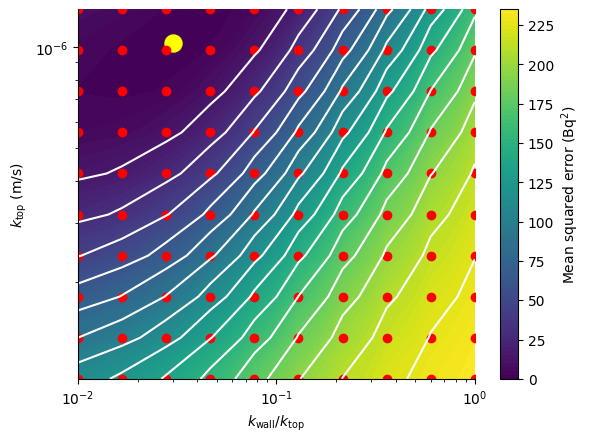

In [20]:
# plot the results
fig, ax = plt.subplots()

c = ax.contourf(k_top_to_k_wall_ratio_range, baby_model.k_top * k_top_factor_range, ZZ, levels=100)
plt.scatter(
    [baby_model.k_wall/baby_model.k_top],
    [baby_model.k_top],
    color="yellow",
    s=150
)
ax.contour(k_top_to_k_wall_ratio_range, baby_model.k_top *k_top_factor_range, ZZ, levels=20, colors="white")
XX, YY = np.meshgrid(k_top_to_k_wall_ratio_range, (baby_model.k_top * k_top_factor_range).magnitude)
plt.scatter(
    XX,
    YY,
    color="red",
)


plt.colorbar(c, label="Mean squared error (Bq$^2$)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k_\mathrm{wall}/k_\mathrm{top}$")
plt.ylabel(r"$k_\mathrm{top}$ (m/s)")

# plt.xlim(-2, 1)
